In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download historical BTC-USD data
btc = yf.download("BTC-USD", start="2020-01-01", interval="1d")

# Optional: Reset index if you want 'Date' as a column
btc.reset_index(inplace=True)

# Flatten the multi-index columns
btc.columns = btc.columns.droplevel(1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
btc['log-return'] = np.log(btc['Close']).diff()

In [4]:
# Parameters
initial_capital = 1
floor_percentage = 0.70  # floor = 80% of initial capital

risk_free_rate_annual = 0.00  # 2% annual risk-free rate
days = 365  # 1 years

safe_growth = (1 + risk_free_rate_annual) ** (1/days)

In [5]:
floor = initial_capital * floor_percentage

In [6]:
btc_ret = btc['log-return'].dropna()

# Parllel Worlds with Bootstrapping
m = 100000 # number of paths
t = 365 # investing time
rearrange_return = np.random.choice(btc_ret, size=(m, days), replace=True)

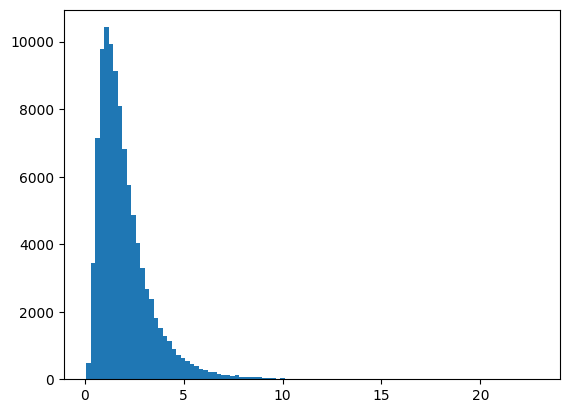

In [7]:
plt.hist(np.exp(np.sum(rearrange_return, axis=1)), bins=100);

In [8]:
rebalance_frequency_index = range(1, 21)
multiplier_index = np.arange(2, 5.1, 0.1)
mean = pd.DataFrame(np.nan, index=multiplier_index, columns=rebalance_frequency_index)
median = pd.DataFrame(np.nan, index=multiplier_index, columns=rebalance_frequency_index)
q_th = pd.DataFrame(np.nan, index=multiplier_index, columns=rebalance_frequency_index)

In [9]:
from tqdm.notebook import tqdm

In [10]:
def cvar_func(rets: np.array):
    return np.mean(rets[rets < np.quantile(rets, 0.05)])

def element_to_quantile(arr, element):
    arr = np.asarray(arr)
    sorted_arr = np.sort(arr)
    
    # Count how many elements are less than the given element
    rank = np.sum(sorted_arr < element)
    
    # You can use +0.5 to center the estimate (optional)
    q = (rank + 0.5) / len(arr)
    
    return q

In [11]:
for rebalance_frequency in tqdm(rebalance_frequency_index):

    for multiplier in multiplier_index:

        portfolio_value = np.ones(m) * initial_capital
        floor_value = portfolio_value * floor_percentage
        cushion = portfolio_value - floor_value

        risky_allocation = multiplier * cushion
        safe_allocation = portfolio_value - risky_allocation

        for i in range(t):
            if (i + 1) % rebalance_frequency == 0:
                
                portfolio_value = risky_allocation + safe_allocation

                floor_value = portfolio_value * floor_percentage
                cushion = portfolio_value - floor_value

                risky_allocation = multiplier * cushion
                    
                safe_allocation = portfolio_value - risky_allocation

            rets = np.exp(rearrange_return[:, i])
            risky_allocation = risky_allocation * rets
            safe_allocation = safe_allocation * safe_growth
        
        portfolio_value = risky_allocation + safe_allocation
        
        mean_port = np.mean(portfolio_value)
        median_port = np.median(portfolio_value)
        q = element_to_quantile(portfolio_value, floor)
        
        mean.loc[multiplier, rebalance_frequency] = mean_port
        median.loc[multiplier, rebalance_frequency] = median_port
        q_th.loc[multiplier, rebalance_frequency] = q

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
btc_log_returns = np.exp(np.sum(rearrange_return, axis=1))

In [13]:
btc_log_returns

array([2.88844534, 1.28526171, 1.45899431, ..., 1.72875424, 1.92170783,
       1.68105187], shape=(100000,))

In [14]:
b_and_h = btc_log_returns * initial_capital

In [15]:
floor = initial_capital * floor_percentage

In [16]:
element_to_quantile(b_and_h, floor)

np.float64(0.093035)

In [17]:
# q_th.style.highlight_min(axis=0)

In [18]:
# Get the max value in the entire DataFrame
max_val = median.max().max()
max_val

# Function to apply highlighting
def highlight_max_only(val):
    return 'background-color: yellow' if val == max_val else ''

In [19]:
# Function to apply highlighting
def highlight_max_only(val):
    return 'background-color: yellow' if val == max_val else ''

In [20]:
median.style.map(highlight_max_only)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2.000000,1.418091,1.418016,1.417876,1.417685,1.417651,1.417439,1.417508,1.417416,1.417162,1.417357,1.416989,1.416849,1.416726,1.417058,1.416728,1.416329,1.416690,1.416289,1.416349,1.416787
2.100000,1.437606,1.437561,1.437246,1.437169,1.437178,1.436820,1.436721,1.436872,1.436788,1.436858,1.436629,1.436256,1.436137,1.436342,1.436174,1.435788,1.435994,1.435574,1.435722,1.436341
2.200000,1.456986,1.456948,1.456669,1.456461,1.456633,1.455932,1.456140,1.456261,1.456321,1.455891,1.455922,1.455472,1.455285,1.455405,1.455408,1.454985,1.454863,1.455058,1.455044,1.455679
2.300000,1.476044,1.476060,1.475738,1.475533,1.475608,1.475018,1.475133,1.475178,1.475333,1.474806,1.474989,1.474451,1.474323,1.474738,1.474223,1.473910,1.473884,1.474226,1.474223,1.474772
2.400000,1.494764,1.494851,1.494375,1.494179,1.494496,1.493847,1.493890,1.494060,1.494007,1.493426,1.493854,1.493080,1.493101,1.493364,1.492849,1.492565,1.492551,1.493008,1.493098,1.493536
2.500000,1.513382,1.513063,1.512639,1.512346,1.512733,1.512289,1.512217,1.512648,1.512268,1.512086,1.512195,1.511462,1.511498,1.511765,1.511673,1.510853,1.511224,1.511393,1.511724,1.511746
2.600000,1.531404,1.531297,1.530615,1.530777,1.530817,1.530521,1.530641,1.530484,1.530293,1.530227,1.530319,1.529875,1.529817,1.529780,1.529800,1.529183,1.529785,1.529597,1.529512,1.529688
2.700000,1.549011,1.549113,1.548278,1.548541,1.548722,1.548614,1.548110,1.548548,1.548089,1.548275,1.548215,1.547947,1.547788,1.547922,1.548031,1.547176,1.547561,1.547774,1.547108,1.547343
2.800000,1.566184,1.566174,1.565670,1.565798,1.566120,1.565833,1.565653,1.565786,1.565750,1.565560,1.565617,1.565285,1.565575,1.565076,1.565250,1.564591,1.565280,1.565268,1.564755,1.564914
2.900000,1.583437,1.583157,1.582737,1.582660,1.583113,1.582820,1.582496,1.582972,1.582810,1.582611,1.582667,1.582547,1.582634,1.582203,1.582307,1.582056,1.582432,1.582337,1.581566,1.581762


In [21]:
# Get the max value in the entire DataFrame
max_val = mean.max().max()

# Function to apply highlighting
def highlight_max_only(val):
    return 'background-color: yellow' if val == max_val else ''

mean.style.map(highlight_max_only)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2.000000,1.520116,1.520366,1.520639,1.520870,1.521120,1.521410,1.521606,1.521890,1.522152,1.522354,1.522555,1.522815,1.523098,1.523318,1.523626,1.523859,1.524046,1.524351,1.524465,1.524856
2.100000,1.552290,1.552538,1.552808,1.553039,1.553286,1.553574,1.553769,1.554051,1.554310,1.554511,1.554709,1.554968,1.555247,1.555467,1.555771,1.556004,1.556188,1.556489,1.556602,1.556990
2.200000,1.585147,1.585390,1.585656,1.585884,1.586127,1.586410,1.586601,1.586880,1.587133,1.587331,1.587526,1.587781,1.588053,1.588271,1.588569,1.588799,1.588979,1.589275,1.589384,1.589766
2.300000,1.618702,1.618938,1.619197,1.619420,1.619656,1.619931,1.620118,1.620390,1.620636,1.620828,1.621018,1.621267,1.621530,1.621744,1.622033,1.622257,1.622431,1.622719,1.622824,1.623197
2.400000,1.652970,1.653197,1.653446,1.653662,1.653888,1.654153,1.654333,1.654596,1.654831,1.655016,1.655199,1.655439,1.655691,1.655898,1.656176,1.656392,1.656559,1.656835,1.656935,1.657295
2.500000,1.687965,1.688181,1.688418,1.688623,1.688838,1.689090,1.689260,1.689511,1.689734,1.689910,1.690083,1.690312,1.690550,1.690747,1.691010,1.691217,1.691374,1.691636,1.691729,1.692072
2.600000,1.723705,1.723907,1.724128,1.724321,1.724521,1.724756,1.724916,1.725151,1.725359,1.725523,1.725685,1.725899,1.726120,1.726306,1.726551,1.726745,1.726891,1.727135,1.727221,1.727542
2.700000,1.760205,1.760389,1.760592,1.760770,1.760953,1.761168,1.761314,1.761531,1.761720,1.761870,1.762018,1.762215,1.762416,1.762588,1.762812,1.762990,1.763123,1.763346,1.763424,1.763718
2.800000,1.797482,1.797646,1.797827,1.797986,1.798149,1.798341,1.798471,1.798665,1.798833,1.798967,1.799099,1.799275,1.799453,1.799607,1.799806,1.799966,1.800084,1.800282,1.800351,1.800614
2.900000,1.835552,1.835693,1.835849,1.835986,1.836126,1.836290,1.836402,1.836570,1.836714,1.836829,1.836942,1.837093,1.837246,1.837379,1.837549,1.837687,1.837788,1.837958,1.838016,1.838243


In [22]:
gain = (median - np.median(b_and_h))
gain

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2.0,-0.233938,-0.234013,-0.234152,-0.234343,-0.234378,-0.234589,-0.234521,-0.234613,-0.234867,-0.234671,-0.235040,-0.235180,-0.235303,-0.234971,-0.235301,-0.235699,-0.235339,-0.235740,-0.235680,-0.235242
2.1,-0.214422,-0.214468,-0.214783,-0.214860,-0.214851,-0.215208,-0.215308,-0.215157,-0.215241,-0.215170,-0.215399,-0.215773,-0.215892,-0.215687,-0.215854,-0.216241,-0.216035,-0.216454,-0.216307,-0.215688
2.2,-0.195042,-0.195081,-0.195359,-0.195568,-0.195396,-0.196097,-0.195888,-0.195768,-0.195708,-0.196138,-0.196107,-0.196556,-0.196743,-0.196624,-0.196620,-0.197044,-0.197165,-0.196971,-0.196985,-0.196350
2.3,-0.175984,-0.175969,-0.176291,-0.176495,-0.176420,-0.177010,-0.176896,-0.176851,-0.176696,-0.177222,-0.177040,-0.177578,-0.177706,-0.177290,-0.177806,-0.178119,-0.178145,-0.177803,-0.177806,-0.177256
2.4,-0.157264,-0.157177,-0.157654,-0.157850,-0.157533,-0.158181,-0.158139,-0.157969,-0.158021,-0.158603,-0.158175,-0.158949,-0.158928,-0.158665,-0.159180,-0.159464,-0.159478,-0.159021,-0.158930,-0.158493
2.5,-0.138647,-0.138965,-0.139390,-0.139683,-0.139296,-0.139739,-0.139812,-0.139381,-0.139761,-0.139943,-0.139834,-0.140567,-0.140531,-0.140264,-0.140356,-0.141176,-0.140805,-0.140635,-0.140304,-0.140283
2.6,-0.120625,-0.120732,-0.121414,-0.121252,-0.121211,-0.121508,-0.121388,-0.121545,-0.121735,-0.121802,-0.121709,-0.122154,-0.122212,-0.122248,-0.122229,-0.122846,-0.122243,-0.122432,-0.122516,-0.122341
2.7,-0.103018,-0.102916,-0.103751,-0.103487,-0.103307,-0.103415,-0.103919,-0.103480,-0.103940,-0.103753,-0.103814,-0.104081,-0.104240,-0.104106,-0.103997,-0.104853,-0.104467,-0.104254,-0.104921,-0.104685
2.8,-0.085845,-0.085854,-0.086358,-0.086230,-0.085909,-0.086196,-0.086376,-0.086243,-0.086279,-0.086469,-0.086412,-0.086743,-0.086454,-0.086953,-0.086778,-0.087438,-0.086748,-0.086760,-0.087274,-0.087115
2.9,-0.068592,-0.068872,-0.069292,-0.069369,-0.068916,-0.069209,-0.069532,-0.069057,-0.069218,-0.069418,-0.069362,-0.069482,-0.069395,-0.069825,-0.069722,-0.069973,-0.069597,-0.069692,-0.070462,-0.070267


In [23]:
cost  = (mean - np.mean(b_and_h))
cost

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2.0,-0.490006,-0.489757,-0.489484,-0.489253,-0.489003,-0.488712,-0.488516,-0.488232,-0.487970,-0.487768,-0.487568,-0.487307,-0.487024,-0.486805,-0.486497,-0.486263,-0.486077,-0.485772,-0.485657,-0.485266
2.1,-0.457832,-0.457585,-0.457314,-0.457084,-0.456836,-0.456549,-0.456354,-0.456071,-0.455813,-0.455612,-0.455413,-0.455154,-0.454875,-0.454656,-0.454351,-0.454119,-0.453935,-0.453633,-0.453521,-0.453132
2.2,-0.424975,-0.424732,-0.424466,-0.424239,-0.423996,-0.423713,-0.423521,-0.423242,-0.422989,-0.422792,-0.422597,-0.422342,-0.422069,-0.421852,-0.421553,-0.421324,-0.421144,-0.420848,-0.420739,-0.420356
2.3,-0.391420,-0.391184,-0.390925,-0.390702,-0.390467,-0.390191,-0.390005,-0.389732,-0.389487,-0.389295,-0.389105,-0.388856,-0.388592,-0.388379,-0.388090,-0.387865,-0.387691,-0.387404,-0.387299,-0.386925
2.4,-0.357153,-0.356926,-0.356676,-0.356461,-0.356234,-0.355969,-0.355790,-0.355527,-0.355291,-0.355106,-0.354924,-0.354684,-0.354431,-0.354225,-0.353947,-0.353730,-0.353564,-0.353288,-0.353188,-0.352828
2.5,-0.322157,-0.321941,-0.321705,-0.321499,-0.321284,-0.321033,-0.320862,-0.320611,-0.320388,-0.320213,-0.320040,-0.319811,-0.319573,-0.319375,-0.319112,-0.318905,-0.318748,-0.318487,-0.318393,-0.318050
2.6,-0.286417,-0.286216,-0.285994,-0.285801,-0.285601,-0.285366,-0.285207,-0.284971,-0.284764,-0.284600,-0.284438,-0.284224,-0.284003,-0.283816,-0.283571,-0.283378,-0.283232,-0.282988,-0.282901,-0.282580
2.7,-0.249917,-0.249733,-0.249530,-0.249352,-0.249170,-0.248954,-0.248808,-0.248592,-0.248402,-0.248252,-0.248104,-0.247908,-0.247706,-0.247535,-0.247311,-0.247133,-0.247000,-0.246777,-0.246699,-0.246404
2.8,-0.212641,-0.212476,-0.212296,-0.212136,-0.211974,-0.211782,-0.211652,-0.211457,-0.211289,-0.211155,-0.211024,-0.210848,-0.210669,-0.210515,-0.210316,-0.210157,-0.210039,-0.209840,-0.209772,-0.209509
2.9,-0.174571,-0.174430,-0.174274,-0.174136,-0.173997,-0.173832,-0.173720,-0.173553,-0.173409,-0.173294,-0.173181,-0.173029,-0.172877,-0.172743,-0.172573,-0.172435,-0.172335,-0.172165,-0.172106,-0.171880


In [24]:
gain[gain > 0] / cost[cost > 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
